In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, LeakyReLU, Dropout, Input, BatchNormalization
from keras.layers import Reshape, Conv2D, Conv2DTranspose, Flatten, Activation
from keras.models import Model,Sequential

In [2]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalization
X_train = X_train.astype(np.float32) / 127.5 - 1
print(X_train.shape, type(X_train))
# Reshape
X_train = X_train.reshape(-1, 28, 28, 1)
print(X_train.shape, type(X_train))

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) <class 'numpy.ndarray'>
(60000, 28, 28, 1) <class 'numpy.ndarray'>


In [3]:
from keras.optimizers import Adam

adam = Adam(lr = 0.0002, beta_1 = 0.5)

In [28]:
NOISE_DIM = 10

generator = Sequential(name='generator')

generator.add(Dense(256 * 7 * 7, input_shape=(NOISE_DIM,)))
generator.add(LeakyReLU())
# 12544
generator.add(Reshape((7,7,256)))  # 왜 reshape??
# (14, 14, 128) 25088
generator.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU())
# (28, 28, 64) 50176
generator.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same' ))
generator.add(BatchNormalization())
generator.add(LeakyReLU())
# (28, 28, 1)
generator.add(Conv2D(1, kernel_size=3, padding='same'))
generator.add(Activation('tanh'))

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 12544)             137984    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 14, 14, 128)       295040    
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 28, 28, 64)        73

In [14]:
generator = Sequential(name='generator')

generator.add(Dense(256 * 7 * 7, input_shape=(NOISE_DIM,), activation='LeakyReLU'))

# 12544
generator.add(Reshape((7,7,256)))  # 왜 reshape??
# (14, 14, 128) 25088
generator.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='LeakyReLU'))

# (28, 28, 64) 50176
generator.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same' ))
generator.add(BatchNormalization())
generator.add(LeakyReLU())
# (28, 28, 1)
generator.add(Conv2D(1, kernel_size=3, padding='same',  activation='tanh'))


generator.summary()

ValueError: ignored

In [15]:
128*8*8

8192

In [17]:
from tensorflow.keras.initializers import RandomNormal

discriminator = Sequential(name = 'discriminator')

discriminator.add(Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=(28,28,1)))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 4, 4, 128)       

In [18]:
discriminator.compile(loss='binary_crossentropy',optimizer=adam)

In [29]:
discriminator.trainable = False

gan_input = Input(shape = (NOISE_DIM,))
x = generator(gan_input)
output = discriminator(x)

In [30]:
gan = Model(gan_input, output, name='gan')
gan.summary()

Model: "gan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
generator (Sequential)       (None, 28, 28, 1)         508161    
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 94721     
Total params: 602,882
Trainable params: 507,777
Non-trainable params: 95,105
_________________________________________________________________


In [31]:
gan.compile(loss='binary_crossentropy', optimizer = adam)

In [41]:
def get_batches(data, batch_size):
  batches = []

  for i in range(data.shape[0] // batch_size):
    batch = data[i* batch_size : (i + 1) * batch_size]
    batches.append(batch)
  print(np.asarray(batches).shape)
  return np.asarray(batches)
  # 128 개씩 468번 도는 함수

In [39]:
X_train.shape[0]//128

468

In [35]:
def visualize_training(epoch, d_losses, g_losses):

  print('epoch :', epoch)
  noise = np.random.normal(0, 1, size=(24, NOISE_DIM))
  generated_imges = generator.predict(noise)
  print(generated_images.shape, type(generated_images))
  generated_imges = generated_images.reshape(-1,28,28)

  plt.figure(figsize=(8,4))
  for i in range(generated_images.shape[0]):
    plt.subplot(4, 6, i+1)
    plt.imshow(generated_images[i], interpolation ='nearest', cmap='Greys_r')
    plt.axis('off')
  plt.tight_layout()
  plt.show()

(468, 128, 28, 28, 1)
epoch : 1
(128, 28, 28, 1) <class 'numpy.ndarray'>


TypeError: ignored

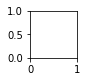

In [42]:
%%time

EPOCHS = 50
BATCH_SIZE = 128

d_losses = []
g_losses = []

for epoch in range(1, EPOCHS + 1):
  # batch 별 학습
  for real_images in get_batches(X_train, BATCH_SIZE):
    # Random Noise 생성
    input_noise = np.random.uniform(-1, 1, size = [BATCH_SIZE, NOISE_DIM])
    # Fake Image 데이터 생성
    generated_images = generator.predict(input_noise)
    # 'gan' 학습용 X 데이터 정의
    x_dis = np.concatenate([real_images, generated_images])
    # 'gan' 학습용 y 데이터 정의
    y_dis = np.zeros(2 * BATCH_SIZE)
    y_dis[:BATCH_SIZE] = 1

    # 'discriminator' 학습
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(x_dis, y_dis)
    # 'gan' 학습
    noise = np.random.uniform(-1, 1, size = [BATCH_SIZE, NOISE_DIM])
    y_gan = np.ones(BATCH_SIZE)
    # 'discriminator' 학습 정지
    discriminator.trainable = False
    g_loss = gan.train_on_batch(noise, y_gan)

  d_losses.append(d_loss)
  g_losses.append(g_loss)

  # 생성 결과 시각화
  if epoch == 1 or epoch % 5 == 0:
    visualize_training(epoch, d_losses, g_losses)